# Introduction
## Sales Forecasting Model
This repository contains a multiple linear regression model for sales forecasting built in Python using the statsmodels library. The model is designed to capture both seasonal patterns and special holiday effects by incorporating monthly dummy variables as well as holiday dummy variables for periods such as New Year, Golden Week, and Obon.

- Data Cleaning and Preprocessing:
Raw data is imported from a CSV file, where date fields are converted to datetime objects and numeric fields (like Sales and Digital_Ads) are cleaned by removing commas and converting them to appropriate numeric types.
- Feature Engineering:
In addition to key advertising metrics (TVCM_GPR, Print_Media, Offline_Ads, Digital_Ads), the model includes dummy variables to capture monthly seasonality (e.g., “2月” to “12月”) and special holiday effects (e.g., New Year, Golden Week, and Obon).
- Model Building:
The regression model is built using historical “Actual” sales data. The data is split into training and test sets, and an OLS regression model is fit on the training data.
- Model Evaluation and Forecasting:
The model’s performance is evaluated on the test set using metrics such as RMSE and R². Subsequently, the model is applied to forecast future sales for records marked as “Forecast”. Both the forecasted values and residuals are visualized to assess model performance.

This base model provides a clear structure for understanding how seasonal and holiday influences can be integrated into a sales forecasting model, serving as a foundation for further refinement and development.

In [1]:
!pip install japanize_matplotlib
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
input_file ="../data/sales_data.csv"
df = pd.read_csv(input_file)
df.head()

,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type
0,9/7/15,"5,554,981",58.86750,20340000,5890000,"23,080",Actual
1,9/14/15,"6,071,669",235.18125,15470000,5740000,"29,979",Actual
2,9/21/15,"5,798,657",252.18375,8325000,0,"23,784",Actual
3,9/28/15,"6,235,157",75.25500,0,0,"26,732",Actual
4,10/5/15,"6,861,105",0.00000,0,0,"28,823",Actual


In [3]:
df.tail()

,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type
116,11/27/17,NaN,79.3800,15450000,0,"31,769",Forecast
117,12/4/17,NaN,41.4900,9930000,0,"34,799",Forecast
118,12/11/17,NaN,0.0000,16280000,0,"31,907",Forecast
119,12/18/17,NaN,81.2625,13350000,5890000,"31,048",Forecast
120,12/25/17,NaN,44.5725,15030000,9150000,"59,196",Forecast


# Preprocess

In [4]:
df.isnull().sum()

Date            0
Sales          16
TVCM_GPR        0
Print_Media     0
Offline_Ads     0
Digital_Ads     0
Record_Type     0
dtype: int64

In [5]:
df.duplicated(subset=['Date']).sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         121 non-null    object 
 1   Sales        105 non-null    object 
 2   TVCM_GPR     121 non-null    float64
 3   Print_Media  121 non-null    int64  
 4   Offline_Ads  121 non-null    int64  
 5   Digital_Ads  121 non-null    object 
 6   Record_Type  121 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 6.7+ KB


In [7]:
df['Sales'] = pd.to_numeric(df['Sales'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Digital_Ads'] = pd.to_numeric(df['Digital_Ads'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Offline_Ads'] = pd.to_numeric(df['Offline_Ads'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['TVCM_GPR'] = pd.to_numeric(df['TVCM_GPR'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
df['Print_Media'] = pd.to_numeric(df['Print_Media'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         121 non-null    object 
 1   Sales        121 non-null    int64  
 2   TVCM_GPR     121 non-null    float64
 3   Print_Media  121 non-null    int64  
 4   Offline_Ads  121 non-null    int64  
 5   Digital_Ads  121 non-null    int64  
 6   Record_Type  121 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 6.7+ KB


# Add Monthly Dummy Variable

In [8]:
import pandas as pd
import numpy as np


df['Date'] = pd.to_datetime(df['Date'])

def count_days_in_week(start_date):
    counts = {f'{i}月': 0 for i in range(1, 13)}
    for i in range(7):
        current_day = start_date + pd.Timedelta(days=i)
        month_str = f'{current_day.month}月'
        counts[month_str] += 1
    return pd.Series(counts)

dummy_columns = [f'{i}月' for i in range(1, 13)]

if not all(col in df.columns for col in dummy_columns):
    month_dummies = df['Date'].apply(count_days_in_week)
    df = pd.concat([df, month_dummies], axis=1)
else:
    print("Monthly dummy columns already exist. Skipping concatenation.")

print(df.tail(20))

          Date    Sales   TVCM_GPR  Print_Media  Offline_Ads  Digital_Ads  \
101 2017-08-14  6424589    0.00000     12785000            0        51122   
102 2017-08-21  5308052   39.29250     12510000            0        45519   
103 2017-08-28  5637103    0.00000     12890000            0        33703   
104 2017-09-04  6250997   36.44250     15080000            0        38845   
105 2017-09-11        0  235.18125     15470000      5740000        23830   
106 2017-09-18        0  252.18375      8325000            0        26072   
107 2017-09-25        0   75.25500            0            0        29948   
108 2017-10-02        0    0.00000            0            0        34220   
109 2017-10-09        0   44.62125            0            0        29145   
110 2017-10-16        0   50.16750            0            0        25991   
111 2017-10-23        0   46.60875            0      8360000        18571   
112 2017-10-30        0  115.46625     15900000      8710000        32704   

/var/folders/_n/cr9xqtgn70g_tclcyk9hd0nw0000gn/T/ipykernel_49611/881936103.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


# Add Public Holiday Dummy

In [9]:
from datetime import datetime, timedelta

holiday_ranges = {
    '正月': [
        (datetime(2015,12,28), datetime(2016,1,3)),
        (datetime(2016,12,26), datetime(2017,1,3)),
        (datetime(2017,12,25), datetime(2018,1,3)),  # Extend if needed
    ],
    'GW': [
        (datetime(2015,4,29), datetime(2015,5,5)),
        (datetime(2016,4,29), datetime(2016,5,5)),
        (datetime(2017,4,29), datetime(2017,5,5)),
    ],
    'お盆': [
        (datetime(2015,8,13), datetime(2015,8,16)),
        (datetime(2016,8,13), datetime(2016,8,16)),
        (datetime(2017,8,13), datetime(2017,8,16)),
    ]
}

df['正月'] = 0
df['GW'] = 0
df['お盆'] = 0

def intersects_holiday(week_start, holiday_start, holiday_end):
    """
    Returns True if the 7-day window [week_start, week_start+6] intersects
    with [holiday_start, holiday_end].
    """
    week_end = week_start + pd.Timedelta(days=6)
    return not (week_end < holiday_start or week_start > holiday_end)

for idx, row in df.iterrows():
    week_start = row['Date']
    
    for holiday_name, ranges in holiday_ranges.items():
        for (start_date, end_date) in ranges:
            if intersects_holiday(week_start, start_date, end_date):
                df.loc[idx, holiday_name] = 1
                break  


print(df.head(15))



         Date    Sales   TVCM_GPR  Print_Media  Offline_Ads  Digital_Ads  \
0  2015-09-07  5554981   58.86750     20340000      5890000        23080   
1  2015-09-14  6071669  235.18125     15470000      5740000        29979   
2  2015-09-21  5798657  252.18375      8325000            0        23784   
3  2015-09-28  6235157   75.25500            0            0        26732   
4  2015-10-05  6861105    0.00000            0            0        28823   
5  2015-10-12  5987676   44.62125            0            0        24929   
6  2015-10-19  5975534   50.16750            0            0        29918   
7  2015-10-26  5996415   46.60875            0      8360000        25121   
8  2015-11-02  5712700  115.46625     15900000      8710000        25303   
9  2015-11-09  5863532  185.66250      7835000      9050000        26184   
10 2015-11-16  6169764  223.53375      8405000      9600000        32256   
11 2015-11-23  6721802  188.91000     23295000      4690000        33227   
12 2015-11-3

# Split Actual and Forecast Data

In [10]:
df_actual = df[df['Record_Type'] == "Actual"].copy()
df_forecast = df[df['Record_Type'] == "Forecast"].copy()

# Regression Model

In [11]:

Y_actual = df_actual['Sales']
monthly_dummy = [f'{i}月' for i in range(2, 13)]
holiday_dummy = ['正月', 'GW', 'お盆']
X_actual = df_actual[['TVCM_GPR', 'Print_Media', 'Offline_Ads', 'Digital_Ads'] + monthly_dummy + holiday_dummy]
X_actual = sm.add_constant(X_actual)  

X_train, X_test, y_train, y_test = train_test_split(X_actual, Y_actual, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()
print("Training Model Summary:")
print(model.summary())

y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
print("Test RMSE:", test_rmse)
print("Test R-squared:", test_r2)

Training Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     12.63
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           7.37e-15
Time:                        10:38:12   Log-Likelihood:                -1214.8
No. Observations:                  84   AIC:                             2468.
Df Residuals:                      65   BIC:                             2514.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.431e+06   2

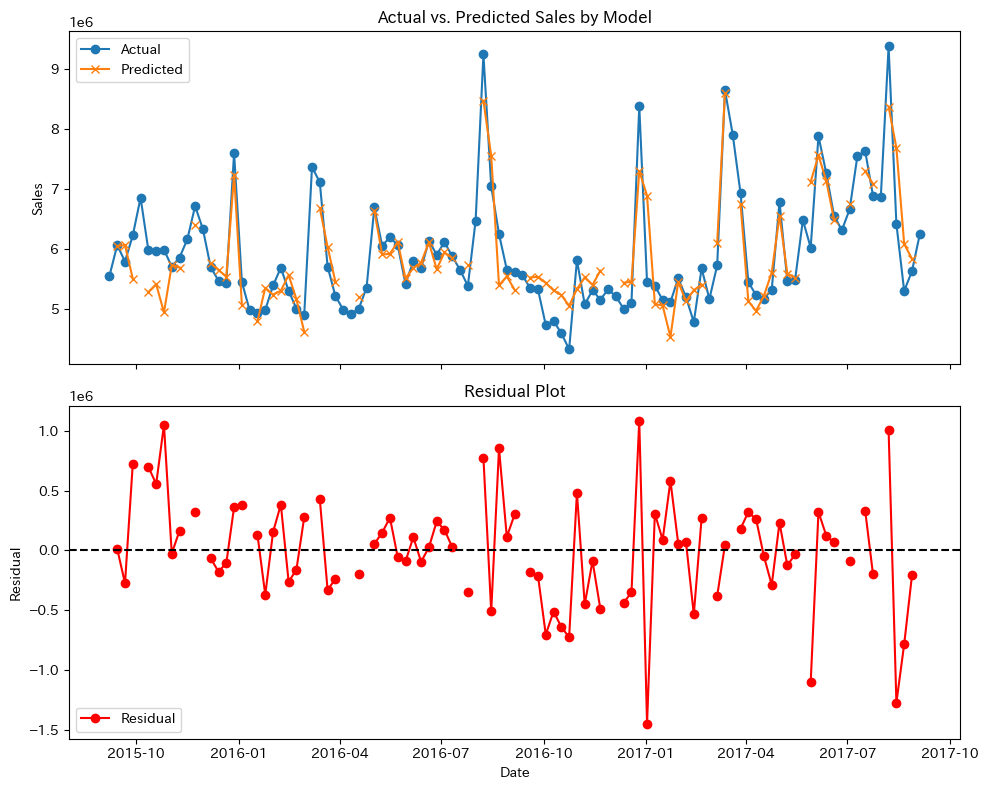

In [12]:
df_actual['Predicted'] = model.fittedvalues
df_actual['Residual'] = model.resid

df_actual.sort_values('Date', inplace=True)


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(df_actual['Date'], df_actual['Sales'], label='Actual', marker='o')
axes[0].plot(df_actual['Date'], df_actual['Predicted'], label='Predicted', marker='x')
axes[0].set_ylabel('Sales')
axes[0].set_title('Actual vs. Predicted Sales by Model')
axes[0].legend()

axes[1].plot(df_actual['Date'], df_actual['Residual'], label='Residual', color='red', marker='o')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_ylabel('Residual')
axes[1].set_xlabel('Date')
axes[1].set_title('Residual Plot')
axes[1].legend()

plt.tight_layout()
plt.show()

# Insight

Here’s an insight into the model based on the provided results:

1. Overall Model Fit (Training):
- The training model explains about 78% of the variance in Sales (R² = 0.778, Adjusted R² = 0.716), which indicates a fairly strong fit on the training data.
- The overall F-statistic is significant (p ≈ 7.37e-15), showing that the predictors, as a group, significantly explain the variation in Sales.

2. Key Predictors:
- TVCM_GPR (coef ≈ 1695, p = 0.037): This predictor is statistically significant, suggesting that higher TVCM_GPR is associated with increased Sales.
- Print_Media (coef ≈ 0.0203, p = 0.001): A significant positive effect indicates that more spending on print media is linked to higher Sales.
- Offline_Ads (coef ≈ -0.0489, p = 0.002): The negative coefficient implies that, surprisingly, increases in Offline Ads are associated with a decrease in Sales, which may warrant further investigation.
- Digital_Ads (coef ≈ 24.41, p < 0.001): This variable has a strong, highly significant positive impact on Sales.

3. Seasonal and Holiday Effects:
- Some monthly dummy variables (e.g., for March and November) and all the holiday dummies—正月 (New Year), GW (Golden Week), and お盆 (Obon)—are statistically significant.
- These dummy variables help capture seasonal patterns and special holiday effects on Sales, indicating that these time periods have distinct impacts on the outcome.

4. Model Diagnostics:
- The high condition number (~1.22e+08) is a red flag for multicollinearity. This suggests that some of the predictors (especially the dummy variables) are highly correlated, which can lead to unstable coefficient estimates.
- Residual diagnostics (Omnibus and Jarque-Bera tests) indicate some departure from normality, although the Durbin-Watson statistic (2.248) suggests little autocorrelation.

5. Test Set Performance:
- The test RMSE is approximately 664,998, meaning that on average, the model’s predictions deviate from the actual Sales by about 665,000 units.
- The test R² is about 0.420, indicating that the model explains only around 42% of the variance in Sales on unseen data. This drop from the training R² suggests that the model might be overfitting or that the relationship between predictors and Sales is less stable out-of-sample.

6. Overall Insight:
While the model shows a strong fit on the training data (with around 78% variance explained), its performance on the test set is considerably lower (with an R² of 42%). Key predictors such as Digital_Ads and Print_Media show robust effects, while TVCM_GPR is only marginally significant, and Offline_Ads surprisingly has a negative impact. The presence of multicollinearity (indicated by the high condition number) and potential overfitting issues suggest that further model refinement—such as addressing collinearity through variable selection or regularization—may be needed to improve its generalization on new data.

This analysis provides a good starting point, and incorporating additional adjustments or exploring alternative modeling techniques might lead to better predictive performance.

# Forecast

Forecast Results:
      Date  Forecast_Sales
2017-09-11    5.908495e+06
2017-09-18    6.127785e+06
2017-09-25    5.712412e+06
2017-10-02    5.441210e+06
2017-10-09    5.392949e+06
2017-10-16    5.325362e+06
2017-10-23    4.729458e+06
2017-10-30    5.798065e+06
2017-11-06    5.767068e+06
2017-11-13    5.601675e+06
2017-11-20    6.152241e+06
2017-11-27    6.067822e+06
2017-12-04    5.720753e+06
2017-12-11    5.708631e+06
2017-12-18    5.477963e+06
2017-12-25    7.574547e+06


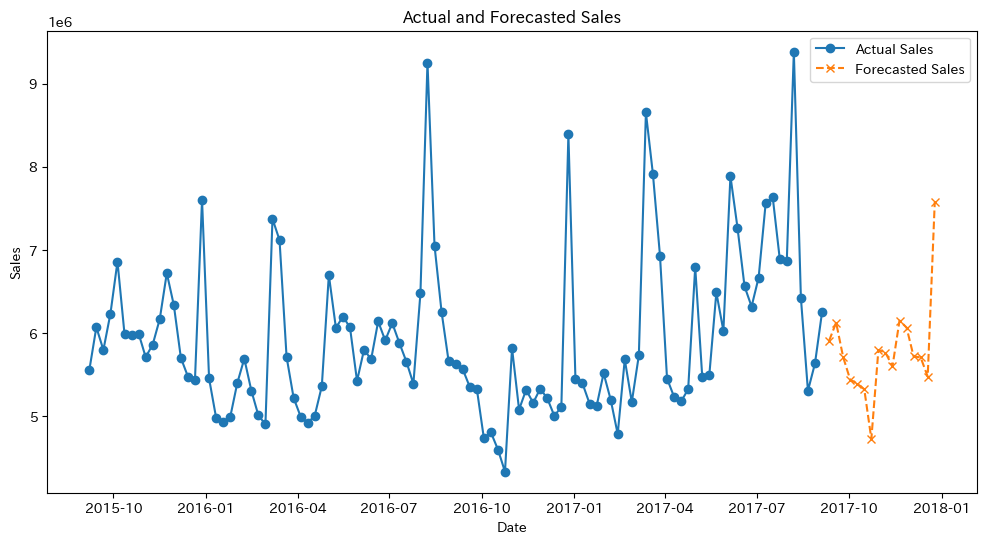

In [13]:
df_actual_combined = pd.concat([df_actual.loc[X_train.index], df_actual.loc[X_test.index]])
df_actual_combined = df_actual_combined.sort_values('Date')

monthly_dummy = [f'{i}月' for i in range(2, 13)]
holiday_dummy = ['正月', 'GW', 'お盆']
X_forecast = df_forecast[['TVCM_GPR', 'Print_Media', 'Offline_Ads', 'Digital_Ads'] + monthly_dummy + holiday_dummy]
X_forecast = sm.add_constant(X_forecast)

df_forecast['Forecast_Sales'] = model.predict(X_forecast)

df_combined = pd.concat([df_actual_combined, df_forecast])
df_combined = df_combined.sort_values('Date')

print("Forecast Results:")
print(df_forecast[['Date', 'Forecast_Sales']].to_string(index=False))

plt.figure(figsize=(12,6))
plt.plot(df_actual_combined['Date'], df_actual_combined['Sales'], label='Actual Sales', marker='o')
plt.plot(df_forecast['Date'], df_forecast['Forecast_Sales'], label='Forecasted Sales', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual and Forecasted Sales')
plt.legend()
plt.show()